## **Physics 77 Final Project**

Keith Chiang (SID: 3039957102)

# Setup:

## Downloading the data:

In [2]:
import numpy as np
import h5py
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.stats import norm
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [3]:
# Downloading this h5 file from the web
import os
os.system("wget https://portal.nersc.gov/project/m3438/physics77/data/datalhc.h5")

0

In [4]:
# Open h5 file
h = h5py.File("datalhc.h5",'r')

# Retrieve the data array
data = h["dataset"][:]

## Finding the diphoton mass from the data

In [5]:
# Components of the momentum
def px(pt, phi):
    return pt*np.cos(phi)

def py(pt,phi):
    return pt*np.sin(phi)

def pz(pt, eta):
    return pt*np.sinh(eta)


# Mass of a particle or a multi-particle system
def mass(E,px,py,pz):
    return np.sqrt((E**2 - (px**2+py**2+pz**2)))

# Diphoton momentum
px_yy = px(data[:,0],data[:,2])+px(data[:,4],data[:,6])
py_yy = py(data[:,0],data[:,2])+py(data[:,4],data[:,6])
pz_yy = pz(data[:,0],data[:,1])+pz(data[:,4],data[:,5])

# Energy of the diphoton system
E_yy = data[:,3]+data[:,7]

# Diphoton mass
m_yy = mass(E_yy,px_yy,py_yy,pz_yy)

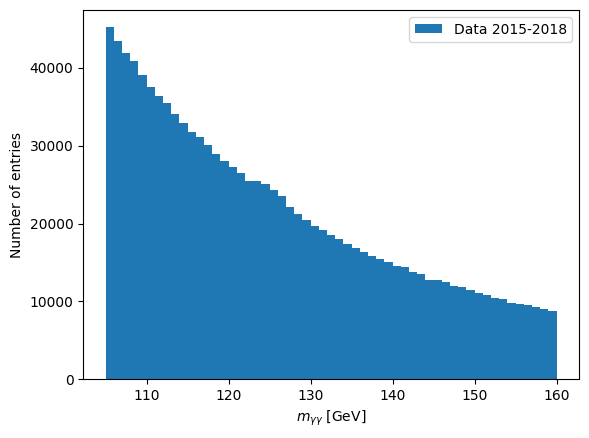

In [6]:
# Plot Diphoton mass
obs, binedges, others = plt.hist(m_yy, bins=55, range=(105, 160), label='Data 2015-2018')
plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
plt.ylabel('Number of entries')
plt.legend()

# Part 1: Significance and Signal Strength

In [7]:
# 4th Polynomial function
def poly4(myy,c):
    return 1 + c[0]*myy + c[1]*myy**2 + c[2]*myy**3 + c[3]*myy**4

# Function for a signal PDF
def sigpdf(myy,mean,std):
    return norm.pdf(myy,mean,std)

# Log Poisson Function
def logPoisson(k, Lambda):
    return poisson.logpmf(k, Lambda)

In [8]:
# Negative log-likelihood for a polynomial model
def NLLpoly(c, obs):
    x = np.linspace(105.5,159.5,55)
    exp = poly4(x, [c[0],c[1],c[2],c[3]])*c[4]
    NLL = -1*logPoisson(obs,exp).sum()
    return NLL

# Negative log-likelihood for a polynomial model with background subtraction
def NLLbkgpoly(c, obs):
    x = np.linspace(105.5,159.5,55)
    exp = poly4(x, [c[0],c[1],c[2],c[3]])*c[4]
    obs_selected = np.hstack( (obs[0:15] , obs[25:55]) )
    exp_selected = np.hstack( (exp[0:15] , exp[25:55]) )
    NLL = -1*logPoisson(obs_selected,exp_selected).sum()
    return NLL

# Negative log-likelihood for a model with a polynomial and a signal component
def NLLSpluspoly(c, obs):
    x = np.linspace(105.5,159.5,55)
    exp = poly4(x, [c[0],c[1],c[2],c[3]])*c[4] + sigpdf(x,125,1.6)*c[5]
    NLL = -1*logPoisson(obs,exp).sum()
    return NLL

## Finding initial coefficients

In [9]:
# Initial conditions
result = minimize(NLLbkgpoly,x0=[-10,100,1,1,1],args=(obs),method='Nelder-Mead')
print(result)

c1 = result.x
print('Pay attention to the NLL value {:6.3f}'.format(result.fun))


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 51351.97543771079
             x: [-1.630e+01  1.864e+02  1.833e+00 -1.841e-02  1.377e-02]
           nit: 366
          nfev: 634
 final_simplex: (array([[-1.630e+01,  1.864e+02, ..., -1.841e-02,
                         1.377e-02],
                       [-1.630e+01,  1.864e+02, ..., -1.841e-02,
                         1.377e-02],
                       ...,
                       [-1.630e+01,  1.864e+02, ..., -1.841e-02,
                         1.377e-02],
                       [-1.630e+01,  1.864e+02, ..., -1.841e-02,
                         1.377e-02]]), array([ 5.135e+04,  5.135e+04,  5.135e+04,  5.135e+04,
                        5.135e+04,  5.135e+04]))
Pay attention to the NLL value 51351.975


## Polynomial fit for the data as a whole:

Text(0.5, 1.0, 'Background preliminary fit')

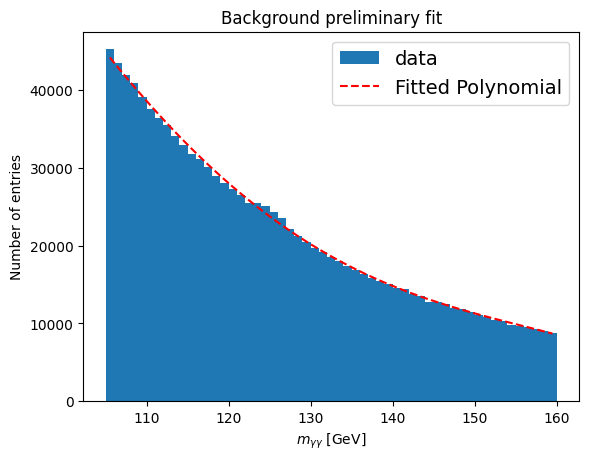

In [10]:
# Values for myy
xfit = np.linspace(105.5,159.5,55)

# Optomization for the coefficients
for i in range(5):
    fit1 = poly4(xfit, [c1[0],c1[1],c1[2],c1[3]])*c1[4]
    result1 = minimize(NLLpoly, x0=c1 , args=(obs), method='Nelder-Mead')
    c1 = result1.x

# Generate initial fit with coefficients
fit1 = poly4(xfit, [c1[0],c1[1],c1[2],c1[3]])*c1[4]
obs, binedges,others =plt.hist(m_yy,bins=55,range=(105,160), label='data')
plt.plot(xfit,fit1,'r--', label='Fitted Polynomial')
plt.legend(fontsize=14)
plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
plt.ylabel('Number of entries')
plt.title('Background preliminary fit')

## Polynomial fit with background subtraction:

Pay attention to the NLL value 310.654


Text(0.5, 1.0, 'Background Fit')

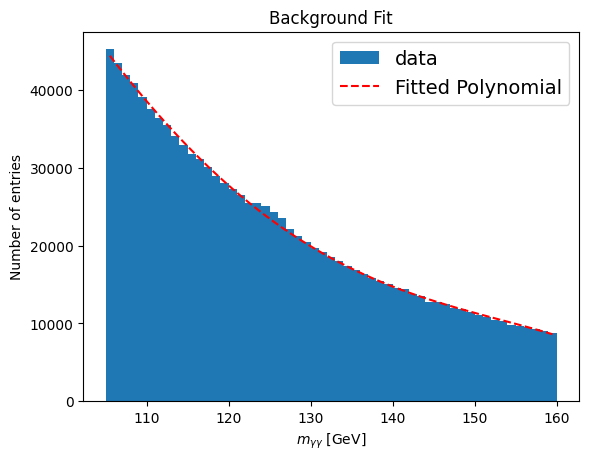

In [11]:
# Minimize the negative log-likelihood for a polynomial model with background subtraction
result_par = minimize(NLLbkgpoly, x0 = c1 ,args=(obs),method='Nelder-Mead')   # this time with Nelder-Mead method
print('Pay attention to the NLL value {:6.3f}'.format(result_par.fun))
c1 = result_par.x

# Calculate the polynomial fit using the new parameters
fit_par = poly4(xfit, [c1[0],c1[1],c1[2],c1[3]])*c1[4]
obs, binedges,others =plt.hist(m_yy , bins=55,range=(105,160), label='data')
plt.plot(xfit,fit_par,'r--', label='Fitted Polynomial')
plt.legend(fontsize=14)
plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
plt.ylabel('Number of entries')
plt.title('Background Fit')

## Signal Region Generation

Text(0.5, 1.0, 'Background for Signal Region')

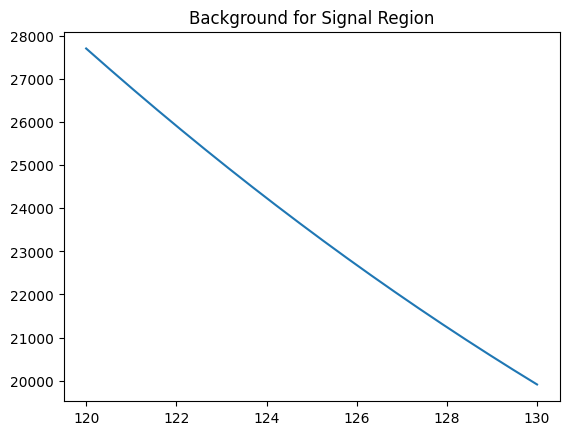

In [12]:
M = 20
xsig = np.linspace(120,130,M)

# Generate background for the signal region
bkg_sig = poly4(xsig, [c1[0],c1[1],c1[2],c1[3]])*c1[4]

plt.plot(xsig,bkg_sig)
plt.title('Background for Signal Region')

### Plot the historgram for the Signal Region:

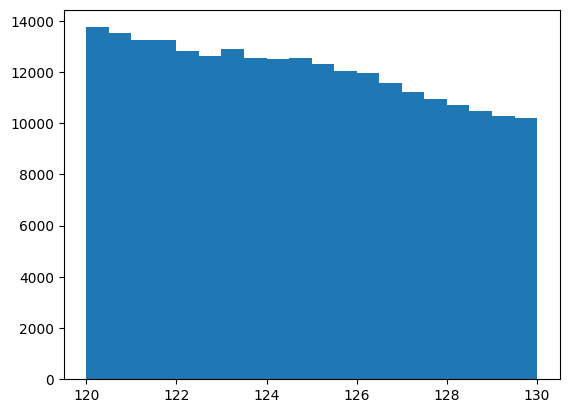

In [13]:
sigobs,edge,others = plt.hist(m_yy, bins=20, range=(120,130), label='Data 2015-2018')

## Polynomial fit for the data after incorporating the signal:

Text(0, 0.5, 'Number of entries')

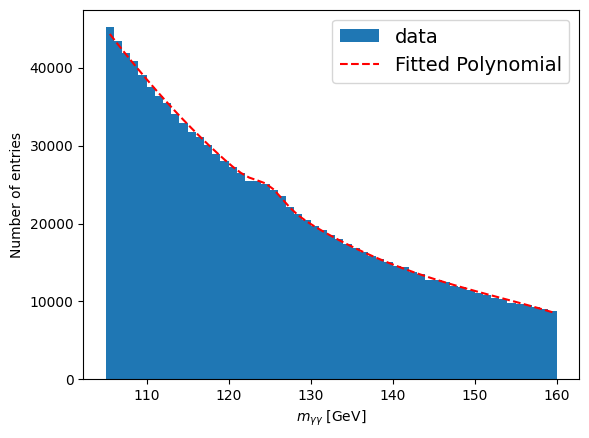

In [14]:
# Initial minimization for a model with a polynomial and a signal component
result2 = minimize(NLLSpluspoly, x0=np.hstack((c1,1000)) , args=(obs), method='Nelder-Mead')
c2 = result2.x
for j in range(5):
    result2 = minimize(NLLSpluspoly, x0=c2 , args=(obs), method='Nelder-Mead')
    c2 = result2.x

    # Calculate the combined polynomial and signal fit using the optimized parameters
    fit2 = poly4(xfit, [c2[0],c2[1],c2[2],c2[3]])*c2[4] + sigpdf(xfit,125,1.6)*c2[5]

obs, binedges, others = plt.hist(m_yy,bins=55, range=(105,160), label='data')

plt.plot(xfit,fit2, 'r--', label='Fitted Polynomial')
plt.legend(fontsize=14)
plt.xlabel('$m_{\gamma\gamma}$ [GeV]')
plt.ylabel('Number of entries')

## Pseudo Experiments to determine the significance:

In [15]:
# Functions to create the sample background and signal plus background hypotheses
def BG(x, c):
    bkg = poly4(x, [c[0],c[1],c[2],c[3]])*c[4]
    return bkg

def SB(x, c):
    spb = poly4(x, [c[0],c[1],c[2],c[3]])*c[4] + sigpdf(x,125,1.6)*c[5]
    return spb

# Number of data points
N = 100000

# Initialize the BG and SB expectations
exp_BG = np.zeros(M)
exp_SB = np.zeros(M)

# Calculate BG and SB expectations by summing the integrals for each bin
for j in range(M):
    exp_BG[j],_ = quad(BG, edge[j], edge[j+1], args=c1)
    exp_SB[j],_ = quad(SB, edge[j], edge[j+1], args=c2)

# Calculate the sample BG and SB
sampleBG = np.random.poisson(exp_BG, size=(N,M))
sampleSB = np.random.poisson(exp_SB, size=(N,M))

## Log Likelyhood Calculations:

In [16]:
# Log Likelyhood Function
def LLR(data):
    LLR = 2 * (logPoisson(data,exp_BG).sum(1) - logPoisson(data,exp_SB).sum(1))
    return LLR

In [17]:
# Calculate the Log Likelyhood of the sample BG and SB
LLRBG = LLR(sampleBG)
LLRSB = LLR(sampleSB)

# Calculate the Negative Log Likelyhood Ratio
NLLR = 2 * (logPoisson(sigobs, exp_BG).sum() - logPoisson(sigobs, exp_SB).sum()) # 2 x (LLB - LLSB)

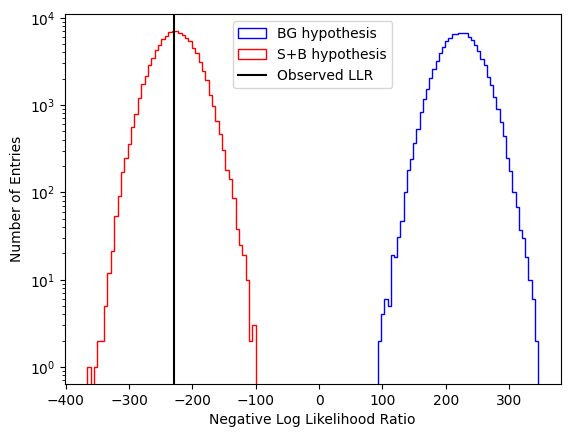

In [18]:
# Plot the BG and SB hypothesis Log Likelyhood functions
fig, ax = plt.subplots()
plt.hist(LLRBG , color='blue', bins=50 , histtype='step' ,label='BG hypothesis' )
plt.hist(LLRSB, color='red',bins=50 , histtype='step' ,label='S+B hypothesis')

# Indicate the Negative Log Likelyhood Ratio
plt.axvline(NLLR, color='black',label='Observed LLR')
plt.xlabel('Negative Log Likelihood Ratio')
plt.ylabel('Number of Entries')
ax.set_yscale('log')
plt.legend()

## Significance Calculation:

In [19]:
# Calculate the bin centers
x_c = (binedges[0:-1] + binedges[1:])/2

# Calculate significance
LLR_obs = -2 * (logPoisson(obs, BG(x_c, c2)).sum() - logPoisson(obs, SB(x_c, c2)).sum())
Z = np.sqrt(LLR_obs)
print(f'The significance is: {Z}')
print(f'Threshold is 5, and Z = {Z} > 5')

The significance is: 14.748469486779165
Threshold is 5, and Z = 14.748469486779165 > 5


### Define background and signal:

In [20]:
bkg = BG(xfit, c2)
sig = sigpdf(xfit, 125, 1.6)

## Signal Strength Calculation:

In [21]:
NN = 100000
mu = np.linspace(5000,6000,NN)

def exp(mu):
    expectation = mu*sig + bkg
    return expectation

def NLLR(mu):
    NLLR = np.ones(0)
    for muu in mu:
        nllr = -2*(logPoisson(obs, exp(muu)).sum() - logPoisson(obs, bkg).sum())
        NLLR = np.hstack((NLLR, nllr))
    return NLLR

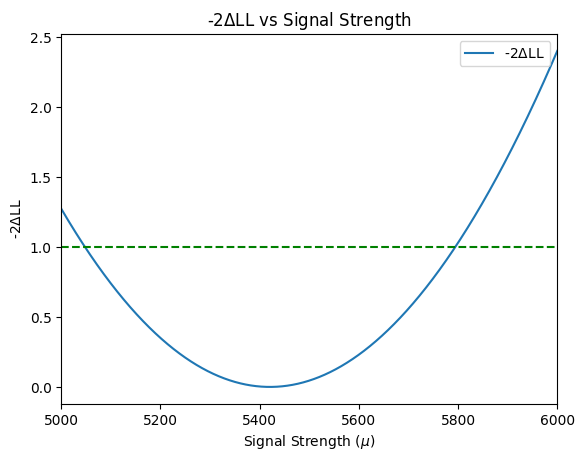

In [22]:
LL = NLLR(mu) - np.min(NLLR(mu))

plt.plot(mu, LL, label='-2$\Delta$LL')
plt.title('-2$\Delta$LL vs Signal Strength')
plt.xlim(5000, 6000)
plt.xlabel('Signal Strength ($\mu$)')
plt.ylabel('-2$\Delta$LL')
plt.plot([5000, 6000], [1, 1], 'g--')
plt.legend()

In [23]:
mu_central = float(mu[np.where(NLLR(mu) == np.min(NLLR(mu)))])
mu_lower_bound = mu[np.where((mu < mu_central)*(LL <= 1))][0]
mu_upper_bound = mu[np.where((mu > mu_central)*(LL <= 1))][-1]

mu_error_minus = mu_lower_bound - mu_central
mu_error_plus = mu_upper_bound - mu_central

In [24]:
print(f"The central value of signal strength is:  {mu_central}")
print(f"The minus one sigma error of signal strength is: {mu_error_minus}")
print(f"The plus one sigma error of signal strength is: {mu_error_plus}")

The central value of signal strength is:  5420.654206542065
The minus one sigma error of signal strength is: -372.7937279372791
The plus one sigma error of signal strength is: 373.55373553735535


# Part Two: Mass Measurement

In [25]:
# Negative loglikelyhood function for Mass Measurement
def NLLSpluspoly_MM(c, obs, m_H):
    exp = poly4(xfit, [c[0],c[1],c[2],c[3]])*c[4] + sigpdf(xfit,m_H,1.6)*c[5]
    NLL = -1*poisson.logpmf(obs,exp).sum()
    return NLL

In [26]:
# Values for m_H
m_H1 = np.linspace(125,126,300)

# Background-only Optimization
BGonly_result = minimize(NLLpoly, x0=c1, args=(obs), method='Nelder-Mead')
BGonly_NLL = BGonly_result.fun

c2 = np.hstack((c1,1000))

# Initialize NLL
NLL = np.ones(0)

# Loop over m_H values
for mH1 in m_H1:

    # Initial Negative Log-Likelihood
    initalNLL = NLLSpluspoly_MM(c2,obs,mH1)

    while True:
        # Minimize Negative Log-Likelihood for the given m_H
        result3 = minimize(NLLSpluspoly_MM, x0=c2, args=(obs,mH1), method='Nelder-Mead')
        c3 = result3.x

        # New NLL after optomization stored in a temporary variable
        temp = result3.fun

        # Check with the threshold
        if abs(temp - initalNLL) < 0.01:   # '0.01' is the threshold
            break

        # Update parameters for the next iteration
        c2 = c3
        initalNLL = temp

    # Calculate final Negative Log-Likelihood and store
    nll = 2*temp
    NLL = np.hstack((NLL,nll))

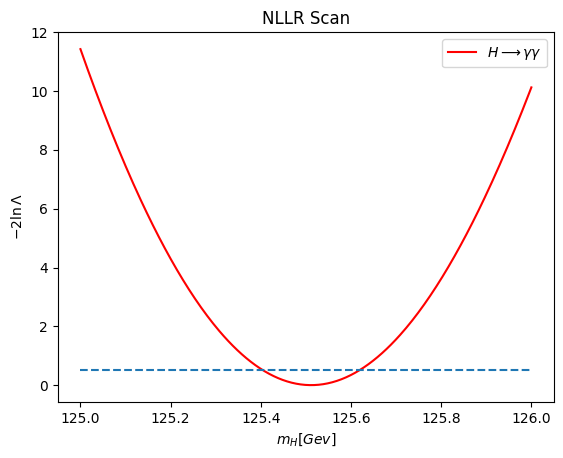

In [34]:
lnlmda = NLL - min(NLL)

plt.plot(m_H1, lnlmda,color = 'red',label = '$H \longrightarrow \gamma\gamma$')
plt.plot([125,126],[0.5,0.5],linestyle = 'dashed')
plt.xlabel('$m_H[Gev]$')
plt.ylabel('$-2\ln \Lambda$')
plt.legend()
plt.title('NLLR Scan');

## Mass Calculation:

In [28]:
m_H_central = (m_H1[np.where(NLL == min(NLL))])[0]
m_H_lower_bound = m_H1[np.where((m_H1 < m_H_central)*(lnlmda <= 0.5))][0]
m_H_upper_bound = m_H1[np.where((m_H1 > m_H_central)*(lnlmda <= 0.5))][-1]

m_H_error_minus = m_H_lower_bound - m_H_central
m_H_error_plus = m_H_upper_bound - m_H_central

In [29]:
print(f"The central value of mass is: {m_H_central}GeV")
print(f"The minus one sigma error of mass is: {m_H_error_minus}GeV")
print(f"The plus one sigma error of mass is: {m_H_error_plus}GeV")

The central value of mass is: 125.51170568561874GeV
The minus one sigma error of mass is: -0.10367892976589133GeV
The plus one sigma error of mass is: 0.10367892976587711GeV


# Look Elsewhere Effect

In [30]:
# Define the actual signal strength observed
mu_actual = c2[5]

# Negative Loglikelyhood function for Look Elsewhere Effect
def NLLSpluspoly_LEE(mu, obs, m_H):
    exp = poly4(xfit, [c2[0],c2[1],c2[2],c2[3]])*c2[4] + sigpdf(xfit,m_H,1.6)*mu
    NLL = -1*poisson.logpmf(obs, exp).sum()
    return NLL

## Pseudo Experiments

In [31]:
# 100 pseudo experiments (small number of trials to shorten computing time)
nn = 400
sampleBG2 = np.random.poisson(bkg, size=(N,55))
m_H2 = np.linspace(115, 145, 31)
mu_max = np.zeros(0)
for i in range (0, nn):
    obs = sampleBG2[i,:]
    mu_temp = np.zeros(0)
    for mH2 in m_H2:
      result4 = minimize(NLLSpluspoly_LEE, x0=1000, args=(obs,mH2), method='Nelder-Mead')
      mu_temp = np.append(mu_temp, result4.x)
      mu_max = np.append(mu_max, np.max(mu_temp))

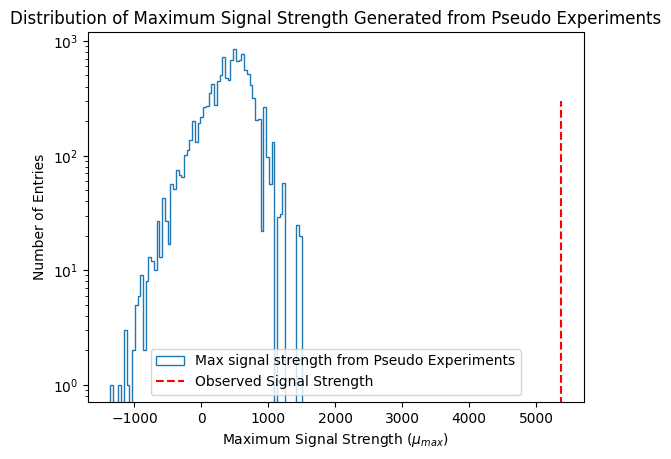

In [32]:
plt.figure()
plt.title('Distribution of Maximum Signal Strength Generated from Pseudo Experiments')
plt.ylabel('Number of Entries')
plt.xlabel('Maximum Signal Strength ($\mu_{max}$)')
plt.yscale('log')
mu_obs, mu_binedges, others = plt.hist(mu_max, bins=70, histtype='step', label='Max signal strength from Pseudo Experiments')
plt.plot([mu_actual, mu_actual], [0,300], 'r--', label='Observed Signal Strength')
plt.legend()
plt.show()

## Global Significance Calculation:

In [33]:
mu_x_c = (mu_binedges[0:-1] + mu_binedges[1:])/2

mu_max_mean = np.mean(mu_x_c)
mu_max_std = np.std(mu_x_c)

# Calculate Z-score
Z = (mu_actual - mu_max_mean) / mu_max_std

print(f"The global significance is: {Z}")

The global significance is: 6.428679219249348
